In [272]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

## Case 5 - Gerrymandering

Write an IP to choose the districts so as to maximize the number of districts that the democrats win.  The input to the function below can be interpreted as follows:

- n: The region to be broken into districts will be an n by n square. Each square is labeled as its row (0,...,n-1) and column (0,...,n-1) number.
- R_map/D_map: An n by n matrix with the number of Republicans/Democrats in each district
- K: The number of districts to create
- C: The allowable absolute population deviation between districts
- D_Capitals: A dictionary that has a key for each district 0,...,K-1 whose value is the capital of each district that must be included within that district.


Return the number districts the democrats won and dictionary with a key for each square, whose value is the assigned district.  

In [273]:
def Gerrymander_IP(n, R_map,D_map,K,C, D_Capitals):
    m = Model()
    z = {}
    x = {}
    d = {}
    r = {}
    M = 10000000
    
    for k in range(0,K):
        for r in range(0,n):
            for c in range(0,n):
                x[(r,c,k)] = m.addVar(0,1,1,GRB.BINARY, name = "x_%i_%i_%i" %(r,c,k))
    for k in range(0,K):
        z[k] = m.addVar(0,1,0,GRB.BINARY,name = "z_%i" %k)
        
    for k in range(0,K):
        m.addConstr(quicksum((x[(r,c,k)]*D_map[r,c]) - (x[(r,c,k)]*R_map[r,c])\
                             for r in range(0,n) for c in range(0,n)) <= M*z[k])
        m.addConstr(quicksum((x[(r,c,k)]*R_map[r,c]) - (x[(r,c,k)]*D_map[r,c])\
                             for r in range(0,n) for c in range(0,n)) <= M*(1-z[k]))
        for j in range(0,K):
            m.addConstr(quicksum(x[(r,c,k)]*(R_map[r,c]+D_map[r,c]) for r in range(0,n) for c in range(0,n)) - \
                        quicksum(x[(r,c,j)]*(R_map[r,c]+D_map[r,c]) for r in range(0,n) for c in range(0,n))<= C)
            m.addConstr(quicksum(x[(r,c,k)]*(R_map[r,c]+D_map[r,c]) for r in range(0,n) for c in range(0,n)) - \
                        quicksum(x[(r,c,j)]*(R_map[r,c]+D_map[r,c]) for r in range(0,n) for c in range(0,n))>= -C)
    for r in range(0,n):
        for c in range(0,n):
            m.addConstr(quicksum(x[(r,c,k)] for k in range(0,K))==1)
            
    for k in range(0,K):
        (rcap,ccap) = D_Capitals[k]
        for r in range(0,n):
            for c in range(0,n):
                ew = ""
                ns = ""
                constraints = []
                if r == rcap and c == ccap:
                    m.addConstr(x[(r,c,k)] == 1)
                if r > rcap:
                    ns = "n"
                elif r < rcap:
                    ns = "s"
                if c > ccap:
                    ew = "w"
                elif c < ccap:
                    ew = "e"
                if ns == "n" and r > 0:
                    constraints.append(x[(r-1,c,k)])
                if ns == "s" and r < n-1:
                    constraints.append(x[(r+1,c,k)])
                if ew == "e" and c < n-1:
                    constraints.append(x[(r,c+1,k)])
                if ew == "w" and c > 0:
                    constraints.append(x[(r,c-1,k)])
                if constraints:
                    m.addConstr(quicksum(constraints) >= x[(r,c,k)])
        
    m.setObjective(quicksum(z[k] for k in range(0,K)),GRB.MAXIMIZE)
    m.setParam("OutputFlag", False) 
    m.optimize()
    gerry_map = {}
    for v in m.getVars():
        if v.varName[0] == "x":
            if v.X > 0.5:
                if v.varName[3] == "_" and v.varName[5] == "_":
                    r = int(v.varName[2])
                    c = int(v.varName[4])
                    k = int(v.varName[6])
                if v.varName[3] != "_" and v.varName[6] == "_":
                    r = int(v.varName[2]+v.varName[3])
                    c = int(v.varName[5])
                    k = int(v.varName[7])
                if v.varName[3] != "_" and v.varName[6] != "_":
                    r = int(v.varName[2]+v.varName[3])
                    c = int(v.varName[5]+v.varName[6])
                    k = int(v.varName[8])
                if v.varName[3] == "_" and v.varName[5] != "_":
                    r = int(v.varName[2])
                    c = int(v.varName[4]+v.varName[5])
                    k = int(v.varName[7])
            gerry_map[r,c] = k

    return gerry_map, m.objVal
    
        
        

In [274]:
np.random.seed(100)

#Size of grid
n = 10

#Democratic map
D_map = np.random.randint(50,100,size = (n,n))

#Republican map 
R_map = np.random.randint(50,100,size = (n,n))

#Number of districts
K=4

#Pop diff threshood
C=5

#Captials
D_Capitals = {k:(min(n-1,(int(n/K)*(k+1))), min(n-1,int(n/K)*(K-k))) for k in range(K)}

gerry_map, num_wins = Gerrymander_IP(n, R_map,D_map,K,C, D_Capitals)

assert num_wins == 4



In [275]:

np.random.seed(110)

#Size of grid
n = 20

#Democratic map
D_map = np.random.randint(50,100,size = (n,n))

#Republican map 
R_map = np.random.randint(50,100,size = (n,n))

#Number of districts
K=5

#Pop diff threshood
C=50

#Captials
D_Capitals = {k:(min(n-1,(int(n/K)*(k+1))), min(n-1,int(n/K)*(K-k))) for k in range(K)}

gerry_map, num_wins = Gerrymander_IP(n, R_map,D_map,K,C, D_Capitals)

pop_1 = sum([D_map[l] + R_map[l] for l in  gerry_map if gerry_map[l]==1])
pop_2 = sum([D_map[l] + R_map[l] for l in  gerry_map if gerry_map[l]==2])
pop_3 = sum([D_map[l] + R_map[l] for l in  gerry_map if gerry_map[l]==3])


assert abs(pop_1-pop_2)<=C
assert abs(pop_1 - pop_3)<=C

# Help to check your answer

If you create gerry_map as noted in the problem description, you can use the code below the visualize your choice of districts and check your answer.

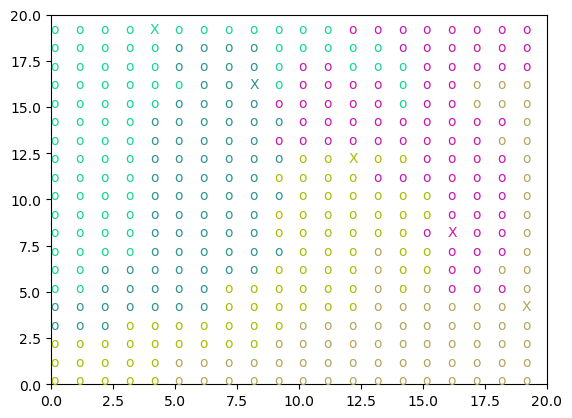

In [276]:
%matplotlib inline



fig,axis = plt.subplots()
axis.set_xlim(0,n)
axis.set_ylim(0,n)
color_dict = {0: '#13D790', 1: '#2E958E', 2: '#ABBC04',\
              3: '#CD15AD', 4: '#B3A55C'}
for loc in gerry_map:
    if (loc[0], loc[1]) in list(D_Capitals.values()):
        #Mark capitals with an X
        axis.annotate(xy = [loc[0], loc[1]],\
                      color = color_dict[gerry_map[loc]] , text = "X")
    else:
        #Other districts get an o
        axis.annotate(xy = [loc[0], loc[1]],color = color_dict[gerry_map[loc]] , text = "o")
    